# General Bellman Stage Form

_Notebook by Sebastian Benthall_

In [1]:
from dataclasses import dataclass, field

import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from typing import Any, Callable, Mapping, Sequence
import xarray as xr

from HARK import distribution
from HARK.utilities import CRRAutility, CRRAutilityP, CRRAutility_inv, CRRAutilityP_inv

In [2]:
from HARK.stage import Stage, backwards_induction, simulate_stage

import cons_stages

In [3]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')

This notebook demonstrates HARK's ability to represent and compose Bellman stages.
This is possible because all Bellman stages have a general form.

In each Bellman stage $S = (\vec{X}, P_\vec{K}, \vec{A}, \Gamma, F, \vec{Y}, T, B)$, the agent:
 - begins in some input states $\vec{x} \in \vec{X}$
 - experiences some exogeneous shocks $\vec{k} \in \vec{K}$ according to distribution $P_\vec{K}$
 - can choose some actions $\vec{a} \in \vec{A}$
 - subject to constraints $\Gamma: \vec{X} \times \vec{K} \rightarrow \mathcal{P}(\vec{A})$
     - For scalar actions, these may be expressed as upper and lower bounds, such that $\Gamma_{lb} \leq a \leq \Gamma_{ub}$:
         - $\Gamma_{ub}: \vec{X} \times \vec{K} \rightarrow \mathbb{R}$
         - $\Gamma_{lb}: \vec{X} \times \vec{K} \rightarrow \mathbb{R}$
         - such that $\Gamma(\vec{x}, \vec{k}) = [\Gamma_{lb}(\vec{x}, \vec{k}), \Gamma_{ub}(\vec{x}, \vec{k})]$
 - experience a reward $F: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$
 - together, these determine some output states $\vec{y} \in \vec{Y}$ via...
 - a **deterministic** transition function $T: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \vec{Y}$
   - _This is deterministic because shocks have been isolated to the beginning of the stage._
 - The agent has a discount factor B for future utility.
     - This is often a constant, such as $\beta$.
     - but it can also be a function $B: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$
     
### Grids

In practice, we will discretized versions of the stage. We will use bold-faced, non-italic $\mathbf{X}$, $\mathbf{K}$, $\mathbf{A}$, and $\mathbf{Y}$ for grids over the input, shock, action, and output spaces.

Note that the shock space $\mathbf{K}$ will normally be generated by discretizing the continuous probability distribution $P_\vec{K}$. We will refer to the discretized probability distribution over $\mathbf{K}$ that preserves point mass values as $\mathbf{P_\vec{K}}$

**TODO: Use grave mark for interpolated functions?**

## Solving one stage 

### Policy Optimization

Given a stage $S$, we often want to know the optimal policy or decision rule $\pi^*(\vec{x}, \vec{k})= \vec{a}^*_{xk}$ that yields the best choice of action given input states and shock realizations.

There are several different techniques available for policy optimization. In general, the more one is able to provide analytic information about the functions in the stage definition, the better a policy optimization algorithm one can employ.

| Method                 | Requirements           | Discretization    | Value Input | Computation  | Products*  |
| ---------------------  |:--------------         | :-------------    | :---------- | :----------  | :--------  |
| Value Optimization     |                        | $$\mathbf{X, K}$$ | $$v_y$$     | Optimization | $\pi^*, q$ |
| First Order Condition  | $F', T'$, $B' = 0$     | $$\mathbf{X, K}$$ | $$v'_y$$    | Rootfinding  | $\pi^*$    |
| Endogenous Gridpoints  | $F'^{-1}, T'$, $B' = 0$| $$\mathbf{Y} $$   | $$v'_y$$    | None         | $\pi_y^*$  |     

#### Value optimization

Given the output value function $v_y : \vec{Y} \rightarrow \mathbb{R}$, the action-value function $q$ is defined as:

$$q(\vec{x}, \vec{k}, \vec{a}) = F(\vec{x}, \vec{k}, \vec{a}) + B(\vec{x},\vec{k},\vec{a}) v_y(T(\vec{x}, \vec{k}, \vec{a}))$$

This can be computed for all points on the grids $\mathbf{X, K}$.

The optimal policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$ is:

$$\pi^*(\vec{x}, \vec{k}) = \underset{\vec{a} \in \Gamma(\vec{x}, \vec{k})}{\mathrm{argmax}} q(\vec{x}, \vec{k}, \vec{a})$$

(This corresponds to Equation 3 in the notes).

#### First Order Condition

Mathematically, the optimization step above truly depends on the marginal value function $v'_y$, and not on $v_y$ (i.e., the solution is indifferent to an additive constant on $v_y$). Optimizing an interpolated value function can can introduce errors. Sometimes, one can get improved results by starting from an interpolatd marginal value function $v'_y$.
 
Given:

 - $v'_y : Y \rightarrow \mathbb{R}$ is the marginal value of output states.
 - A marginal reward function $F' = \frac{\partial F}{\partial \vec{a}}$
 - A marginal transition function $T' = \frac{\partial T}{\partial \vec{a}}$
 - A discount factor $B$ such that $B' = \frac{\partial B}{\partial a} = 0$, i.e. because it is constant.
 
Assuming the $q$ function is concave, then the optimal $\pi^*(\vec{x}, \vec{k}) \in \vec{A}$ will satisfy the first order condition (FOC). This condition is that the marginal action value function $q' =  \frac{\partial q}{\partial \vec{a}}$ is 0:

$$0 = q'(\vec{x}, \vec{k}, \vec{a})$$

$$0 = F'(\vec{x}, \vec{k}, \vec{a}) + B(\vec{x},\vec{k},\vec{a}) v_y'(T(\vec{x}, \vec{k}, \vec{a}))T'(\vec{x}, \vec{k}, \vec{a})$$

(This condition is more complex if $B$ depends on the actions because of the Product Rule of differentiation.)

This can be computed for all points on the grids $\mathbf{X, K}$.

If $q'(\vec{x}, \vec{k}, \Gamma_{lb}(\vec{x}, \vec{k}))$ and $q'(\vec{x}, \vec{k}, \Gamma_{ub}(\vec{x}, \vec{k}))$ have the same sign, then the constraints bind, and
- $\pi^*(\vec{x}, \vec{k}) = \Gamma_{lb}(\vec{x}, \vec{k})$ (negative sign)
- or $\pi^*(\vec{x}, \vec{k}) = \Gamma_{ub}(\vec{x}, \vec{k})$ (positive sign).

**TODO: Nice LaTeX braces and cases for this?**

Computationally, this involves replacing the numerical optimization step with a numerical root-finding step.

#### Endogenous Gridpoints

Sometimes, no computation is needed at all to compute the optimal policy! With a catch.

Given:
 - $v'_y : Y \rightarrow \mathbb{R}$ is the marginal value of output states.
 - A constant marginal transition function $T' = \frac{\partial T}{\partial \vec{a}}$. Note: Some researchers are discovering how to lift this condition!
 - An inverse marginal reward function $F'^{-1} : \mathbb{R} \rightarrow \vec{A}$.
 - A constant discount factor $B$ such that $B' = \frac{\partial B}{\partial a} = 0$, i.e. because it is constant.
 - A grid $\mathbf{Y}$ over output states.

Then we can derive from the FOC that:

$$0 = F'(\vec{x}, \vec{k}, \vec{a}) + B T'(\vec{x}, \vec{k}, \vec{a}) v_y'(T(\vec{x}, \vec{k}, \vec{a}))$$

$$F'(\vec{x},\vec{k},\pi^*_y(\vec{y})) = - B T' v_y'(\vec{y}) $$

$$\pi^*_y(\vec{y})  =  F'^{-1}(- B T' v_y'(\vec{y}))$$

Unlike the other policy optimizing methods, this is computed over a grid over outputs $\mathbf{Y}$ and requires no numerical searching over the action space. This takes $O(|Y|)$ time, but with a very small constant.

Note that this produces the function $\pi^*_y : \vec{Y} \rightarrow \vec{A}$, which chooses the optimal action for a given _output_. This is part of the Endogenous Gridpoints Method (Carroll, 2006), so called because it implies an endogenous grid over actions $\mathbf{A}^* = \pi^*_y(\mathbf{Y})$.

Under special conditions, this function $\pi^*_y$ can be used to efficiently compute the input value function.

**TODO: What happens if $\vec{y}$ is multidimensional? Is it e.g. $\frac{\partial v_y'(\vec{y})}{\partial y_1 \partial y_2}$?**

### Value Backup Methods

When solving a problem with backwards induction, we will want to derive input value function $v_x$ from the output value function $v_y$. This requires solving for the optimal policy, discussed above. Once this is in hand, several methods are available.

| Method                  | Requirements  | Discretization      | Policy      | Value   | Products*  |
| ---------------------   |:------------- | :-------------      | :---------  | :------ | :--------  |
| Value Update            |               | $$\mathbf{X, P_K}$$ | $$\pi^*$$   | $$v_y$$ | $v_x, q$   |
| Analytic Marginal Value | $T'_x, T'_a, $| $$\mathbf{X, P_K}$$ | $$\pi^*$$   |         | $v'_x$     |
| Endogenous Gridpoints?  | $T^{-1}_a$    | $$\mathbf{Y} $$     | $$\pi^*_y$$ | ???     | $v'_x$     |  


#### Basic value backup

With the optimal policy $\pi^*$ in hand, it is possible to compute the input value function $v_x: \vec{X} \rightarrow \mathbb{R}$. 

$$v_x(\vec{x}) = \mathbb{E}_{\vec{k} \in \vec{K}}[q(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))]$$

This can be computed over discretized shock distribution $\mathbf{P_K}$, which includes probability mass values for each point. This step takes time relative to the size of the discretization, $O(|\mathbf{X}||\mathbf{K}|)$.

#### Marginal value backup

**TODO**

Getting $v'_x$ from $v'_y$.

#### Analytic marginal value from marginal reward

See notebook "The Envelope Theorem for Abstract Bellman Stages" for the derivation.

Using the Envelope Theorem, it is possible to derive an expression for the marginal function using the partial derivatives of the transition function and marginal reward function.

Under the following conditions:

- The conditions of the FOC policy solution, described above.
- $B$ is a constant
 - A reward function such that $\frac{\partial F}{\partial \vec{x}} = 0$
 - A discount factor such that $\frac{\partial B}{\partial x} = 0$.

Then:

$$v'_x(\vec{x}) = \mathbb{E}\left[- \frac{T^x(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))}{T^a(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))} F^a(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k})) \right]$$

This method works in generality if the analytic expressions for the partial derivatives are provided.

#### Endogenous Gridpoint Method

Given:
 - an invertible transition function so that $T^{-1}_a: \vec{Y} \times \vec{A} \rightarrow \vec{X}  $ is well defined
   - No shocks allowed!
 - The optimal policy with respect to the output $\pi^*_y$. (See EG Policy optimization above).
 
Then we can create an endogenous grid $\mathbf{X} = T^{-1}_a(\mathbf{Y}, \pi^*_y(\mathbf{Y}))$. This this is $O(|Y|)$ with a low constant.

## Special Points, and Interpolation

Interpolation brings with it a host of challenges when the underlying functions are very curved.

For example, with a CRRA utility function the utility of consuming $0$ resources is $-\infty$. This means both that linear extrapolation from low-but-positive values will be too high, and that when an agent has no choice but to consume 0 resources they will be impossibly miserable.

For this reason we offer a few tricks:

### Transformed value function interpolation

Rather than requiring users to use a linearly interpolated value function $v_x \sim i(\vec{v_x})$, we allow the user to define a transform function $f$ and its inverse $f^{-1}$ such that $v_x \sim f^{-1}(i(f(\vec{v_x})))$.

Commonly, the transformation function $f$ is the inverse of the CRRA utility function.

It can also be exponentiation $e^x$, which is a similar operation. **TODO: What are the theoretical advantages of the inverse utility function over e^x?**

### Solution Points

When it is easy to determine the optimal policy $\pi^*$ or value function $v_x$ for a particular state $x^*$ analytically, but difficult to solve it using optimization, it is useful to input that value directly in the stage definition.

# Portfolio Choice Problem

We demonstrate the expressivity of the general Bellman stage form by representing a well-understood problem, the Portfolio Choice problem.

In this intertemporal choice problem, the agent has two decisions to make at each time step: $c$, how many resources to consume; and $\alpha$, what proportion of their savings to allocate to a risky asset. They earn income every time period; this income is subject to permanent ($\psi$) and transitory ($\theta$) shocks. The risky asset's growth is also subject to a shock ($\eta$). The agent is rewarded for consumption through a CRRA utility function governed by $\rho$.

This problem is implemented and analyzed in other HARK materials. In this notebook, we focus on representing the problem as a series of Bellman stages of the above form, implementing them using HARK's `stage` module, and solving the composed problem with a generic value iteration algorithm.

| Name      | X                | K                       | A             | F        | B                   | Y      |
| --------- | :-------------   | :---------------------- | :-----------  | :-----   | :----               | :----- |
| Investing | $$k, \alpha$$    | $$\mathcal{R} $$        | $$\emptyset$$ |          |                     | $$b?$$ |
| Labor     | $$b$$            | $$\psi, \theta$$        | $$\emptyset$$ |          | $$\psi^{1 - \rho}$$ | $$m$$  |
| Consume   | $$m$$            | $$\emptyset$$           | $$c$$         | $$U(c)$$ |                     | $$a$$  |
| Allocate  | $$a$$            | $$\emptyset$$           | $$\alpha$$    |          |             | $$k, \alpha$$  |
| EndPeriod | $$k, \alpha$$    | $$\emptyset$$           | $$\emptyset$$ |          | $$\beta$$   | $$k, \alpha$$  |

All stages are solved through some form of value backup. If a stage has shocks, the value backup involves taking expectations over the shocks. If the stage has actions, the value backup also requires a policy optimization step.

| Name      | X                | Steps                          | Possible algorithms          | Y      |
| --------- | :-------------   | :----------------------------- | :-----------------           | :----- |
| Investing | $$k, \alpha$$    | Expected value backup          |                              | $$b?$$ |
| Labor     | $$b$$            | Expected value backup          |                              | $$m$$  |
| Consume   | $$m$$            | Optimize $\pi^*$  value backup | VO, FOC, EG                  | $$a$$  |
| Allocate  | $$a$$            | Optimize $\pi^*$, value backup |                              | $$k, \alpha$$  |
| EndPeriod | $$k, \alpha$$    |                                |                              | $$k, \alpha$$  |

When a stage has no shocks, no expectation needs to be taken.

When a stage has no actions, no optimization must be performed.

### A few hacks

We have a small technical problem which is that the CRRA utility function has a value of $-\infty$ when consumption is 0, and this throws off the optimizers.

As a hack, we will define $\epsilon$ (`epsilon` in Python) for the minimum value of resources/consumption that we will use in the discretization of the resource space.

In [4]:
epsilon = 1e-4

HARK's `CRRAutility` does not work with an input of 0. We will patch it to fix this.

In [5]:
CRRAutility_hack = lambda c, gam: float('-inf') if c == 0.0 else CRRAutility(c, gam)
CRRAutilityP_hack = lambda c, gam: float('inf') if c == 0.0 else CRRAutilityP(c, gam)

We are going to need the CRRA constant:

In [6]:
CRRA = 5.0

## Stages

First we define the stages. Then we combine the stages together and solve them recursively.

### Consumption stage

The consumption stage:

* $c \in A_0 = \mathbb{R}$
* $m \in X_0 = \mathbb{R}$
* $a \in Y_0 = \mathbb{R}$
* $\Gamma_0$ ... restricts consumption $c \leq m$
* $F_0(m,c) = CRRA(c, \rho)$
    - $F' = ...$
    - $F'^{-1} = ...$
* $T_0(m,c) = m - c$
    - $\frac{\partial T}{\partial x} = 1$
    - $\frac{\partial T}{\partial m} = -1$
* $B_0 = \beta $

Requires a parameter $\rho$

In [7]:
consumption_stage = cons_stages.consumption_stage

Notice that we have defined a solution points for the $v_x$ and $\pi^*$ at $m = 0$.

Given a value function over stage outputs, we can then compute components of the solution for this stage.

Here `pi_star` represents $\pi^*$, the optimal policy (action) at each input value in the given grid. (There are no shocks in this period, otherwise they would also be included as an argument of $\pi^*$.)

`q` represents $q$, the action-value given the input state $m$ and the optimal action $\pi^*(m)$.

To make it interesting, let's start in the penultimate period where we know that the agent will consume all their resources in the next period.

In [8]:
def consumption_v_y(y : Mapping[str,Any]):
    return CRRAutility_hack(y['a'], CRRA)

pi_star, q = consumption_stage.optimal_policy(
    {'m' : [1, 2, 4, 8, 16]},
    v_y = consumption_v_y
)

Grid size: 5.0


In [9]:
q

<xarray.DataArray (m: 6)>
array([           -inf, -7.83869388e+00, -4.89918360e-01, -3.06198974e-02,
       -1.91374359e-03, -1.19608974e-04])
Coordinates:
  * m        (m) int64 0 1 2 4 8 16

In [10]:
pi_star

<xarray.DataArray (m: 6)>
array([0.       , 0.5020625, 1.0040625, 2.0081875, 4.0163125, 8.0326875])
Coordinates:
  * m        (m) int64 0 1 2 4 8 16

We get the same policy if we solve for $\pi*$ using the marginal value function, root-finding the first order condition.


In [11]:
def consumption_v_y_der(y : Mapping[str,Any]):
    return CRRAutilityP_hack(y['a'], CRRA)

pi_data, q_der_data, y_data = consumption_stage.optimal_policy_foc(
    {'m' : [1, 2, 4, 8, 16]},
    v_y_der = consumption_v_y_der
)

pi_data

Grid size: 5.0


<xarray.DataArray (m: 6)>
array([0.        , 0.50204109, 1.00408218, 2.00816435, 4.01632871,
       8.03265741])
Coordinates:
  * m        (m) int64 0 1 2 4 8 16

In [12]:
q_der_data

<xarray.DataArray (m: 6)>
array([           nan, 1.22213351e-12, 3.81916720e-14, 1.19348975e-15,
       3.72965547e-17, 1.16551734e-18])
Coordinates:
  * m        (m) int64 0 1 2 4 8 16

Because we picked the trivial output value function $v_y = 0$, the best policy is to consume all available resources.

To compute a solution to the stage, the solver requires grids over the input and shock spaces as well as a output value function $v_y$.

In [13]:
c_sol_v_x = consumption_stage.value_backup(
    pi_data,
    {'m' : [1, 2, 4, 8, 16]}, {},
    v_y = consumption_v_y
)

The 'solution object' is an `xarray.Dataset` coordinated over the state and shock spaces that includes data for the $v_x$ input state value function, optimal policy $\pi^*$, and action-value function $q$.

In [14]:
c_sol_v_x.dataset

<xarray.Dataset>
Dimensions:  (m: 6)
Coordinates:
  * m        (m) int64 0 1 2 4 8 16
Data variables:
    v_x      (m) float64 -inf -7.839 -0.4899 -0.03062 -0.001914 -0.0001196
    pi*      (m) float64 0.0 0.502 1.004 2.008 4.016 8.033

In [15]:
c_sol_v_x.pi_star({'m' : 10}, {})

{'c': 5.02041088388218}

Because the inverse marginal reward function `reward_der_inv` is defined for this stage, it is possible to solve for the optimal policy with respect to the stage output $\pi*_y$ using the Endogenous Gridpoint Method.

Here, we adjust the $v'_y$ input to be a discounted version of the CRRA utility function. The optimal policy that gives this output is to consume slightly more than half of the available resources.

In [16]:
def consumption_v_y_der_adjusted(y : Mapping[str,Any]):
    return 0.96 * CRRAutilityP_hack(y['a'], CRRA)

pi_y_star = consumption_stage.optimal_policy_egm(
    {'a' : [1, 2, 4, 8, 16]},
    v_y_der = consumption_v_y_der_adjusted
)

pi_y_star

(<xarray.DataArray (m: 6)>
 array([ 0.        ,  1.01646284,  2.03292568,  4.06585136,  8.13170273,
        16.26340546])
 Coordinates:
   * m        (m) float64 0.0 2.016 4.033 8.066 16.13 32.26,
 <xarray.DataArray (a: 5)>
 array([ 1.01646284,  2.03292568,  4.06585136,  8.13170273, 16.26340546])
 Coordinates:
   * a        (a) int64 1 2 4 8 16)

In [17]:
consumption_stage.solve(
    {'m' : [1, 2, 4, 8, 16]},
    {},
    consumption_v_y)

Grid size: 5.0


<xarray.Dataset>
Dimensions:  (m: 6)
Coordinates:
  * m        (m) int64 0 1 2 4 8 16
Data variables:
    v_x      (m) float64 -inf -7.839 -0.4899 -0.03062 -0.001914 -0.0001196
    pi*      (m) float64 0.0 0.5021 1.004 2.008 4.016 8.033
    q        (m) float64 -inf -7.839 -0.4899 -0.03062 -0.001914 -0.0001196

### Allocation stage

The allocation stage. Note that this is a trivial transition function.:

* $\alpha \in A_1 = \mathbb{R}$
* $a \in X_1 = \mathbb{R}$
* $(a, \alpha) \in Y_1 = \mathbb{R}^2$
* $\Gamma_1$ ... restricts allocation $0 \leq \alpha \leq 1$
* $F_1(a,\alpha) = 0$
* $T_1(a,\alpha) = (a, \alpha)$
* $\beta_1 = 1 $

In [18]:
allocation_stage = cons_stages.allocation_stage

Optimize portfolio allocation $\alpha$ with a more complex value function:

In [19]:
def allocation_v_y(y : Mapping[str,Any]):
    return 0

pi_star, q = allocation_stage.optimal_policy(
    {'a' : [1, 2, 4, 8, 16]},
    v_y = allocation_v_y
)

q

Grid size: 5.0


<xarray.DataArray (a: 5)>
array([0., 0., 0., 0., 0.])
Coordinates:
  * a        (a) int64 1 2 4 8 16

In [20]:
pi_star

<xarray.DataArray (a: 5)>
array([0.26437692, 0.26437692, 0.26437692, 0.26437692, 0.26437692])
Coordinates:
  * a        (a) int64 1 2 4 8 16

### Income stage

The income stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{(\alpha \eta + (1 - \alpha) R) a + \theta}{\psi G} $ 
* $\beta(\psi) = \psi^{1-\rho}$

Requires parameters $R$ and $G$

In [21]:
income_stage = cons_stages.income_stage

TODO: Note here about the 'self-imposed binding constraint' 

In [22]:
def income_v_y(y : Mapping[str,Any]):
    return CRRAutility(y['m'], CRRA) # * 'live' ?

pi_star, q = income_stage.optimal_policy(
    {'a' : [300, 600],
     'alpha' : [0, 1.0]
    },
    {'psi' : [1., 1.1], 
     'theta' : [1., 1.1], 
     'eta' : [1., 1.1],
     # 'live' : [0, 1] 
    }, 
    v_y = income_v_y)

q

Grid size: 32


<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]],

         [[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]]],


        [[[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]],

         [[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]]]],



       [[[[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]],

         [[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]]],


        [[[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]],

         [[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

Because there are no actions to optimize, the $\pi^*$ function data is 'not a number'.

In [23]:
pi_star

<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]],



       [[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

Note that solving this stage involves computing over a large grid, as it is the product of the sizes of the input and shock spaces.

In [24]:
i_sol = income_stage.value_backup(
    pi_star,
    {'a' : [epsilon, 1,2,4], 'alpha' : [epsilon, 0.2, 0.4, 0.6, 0.8, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, income_v_y)

i_sol.v_x({'a' : 3, 'alpha' : 0.25})

<xarray.DataArray 'v_x' ()>
array(-0.00230734)
Coordinates:
    a        int64 3
    alpha    float64 0.25

In [25]:
i_sol.dataset.data_vars

Data variables:
    v_x      (a, alpha) float64 nan -13.96 -13.95 -13.95 ... nan nan nan nan
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan

#### Alternative Composition: splitting independent shocks

Above, we found that the income stage had a very large grid because of the size of the shock space. One optimization we can do with generalized Bellman stages is break down the effects of the independent shock into a separate stages.

#### Investing stage

The investing stage is when the consumer realizes risk-free and risky returns on their savings:

* $A = \emptyset$
* $(a, \alpha) \in X = \mathbb{R}^2$
* $b \in Y = \mathbb{R}$
* Shocks:
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F(a,\alpha) = 0$
* $T(a,\alpha) =  \alpha \eta + (1 - \alpha) R$
* $B = L$

Requires parameters $R$ and $L$.

#### Labor stage

The labor stage is when the consumer experiences permanent and transient income shocks.

* $A = \emptyset$
* $b \in X = \mathbb{R}$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
* $F(a,\alpha) = 0$
* $T(a,\alpha) =  (b + \theta) / (G\psi)$ 
* $B(\psi) = \psi^{1 - \rho}$ 

Note that this labor stage can be further broken down into permanent and transitory shock stages.

In [26]:
investing_stage = cons_stages.investing_stage

labor_stage = cons_stages.labor_stage

### Forward Simulation - single stage

Given:
 - a stage $(\vec{X}, P_\vec{K}, \vec{A}, \Gamma, F, \vec{Y}, T, \beta)$ 
 - a policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$
 - input states $\vec{x}$
 
The stage can be Monte Carlo simulated forward by:
 - Sampling $\vec{k} \sim P_\vec{K}$
 - Determining actions $\vec{a} = \pi(\vec{x}, \vec{k})$
 - Computing reward $F(\vec{x}, \vec{k}, \vec{a})$ and discount factor $\beta(\vec{x}, \vec{k}, \vec{a})$
 - Transitioning to ouput state $\vec{y} = T(\vec{x}, \vec{k}, \vec{a})$

In [27]:
c_sol_v_x.pi_star({'m' : 10},{})

{'c': 5.02041088388218}

In [28]:
simulate_stage(consumption_stage, {'m' : 10}, c_sol_v_x.pi_star)

({}, {'c': 5.02041088388218}, {'a': 4.97958911611782}, -0.00039353463348051145)

In [29]:
simulate_stage(income_stage, {'a' : 10, 'alpha' : 0.5}, i_sol.pi_star)

({'psi': 2.2235157434045782,
  'theta': 2.399339242731408,
  'eta': 2.3097550909093605},
 {},
 {'m': 8.376645274330938},
 0)

## Solving in sequence

We will now solve these stages backwards in sequence, chaining the input value function to one stage into the output value function of the previous stage.

In [30]:
x_grid = np.linspace(epsilon,25,32)
alpha_grid = np.linspace(0,1,16)

i_shock_approx_params = {
            'eta' : 9,
        }

l_shock_approx_params = {
            'psi' : 9, 
            'theta' : 9, 
        }

We are going to start with the final consumption stage, because after this stage the agent has no more opportunities to gain utility.

#### Terminal Consumption

Solve the growth stage with the terminal utility of $0$.

In [31]:
def consumption_v_y_terminated(y : Mapping[str,Any]):
    return 0

c_sol_v_x = consumption_stage.solve(
    {'m' : x_grid},
    {},
    v_y = consumption_v_y_terminated
)

#c_sol_v_x_der = consumption_stage.solve_v_x_der(
#    {'m' : x_grid},
#    {},
#    v_y_der = consumption_v_y_terminated
#)

v_x_der_analytic = consumption_stage.analytic_marginal_value_backup(
    c_sol_v_x.dataset['pi*'],
    {'m' : x_grid},
    {}
)

Grid size: 32.0


In [32]:
# 
# This is no good for the terminated period because there the
# policy is bound by constraints not the FOC condition.
#
#v_x_der_backup = consumption_stage.marginal_value_backup(
#    c_sol_v_x.dataset['pi*'],
#    {'m' : x_grid},
#    {},
#    consumption_v_y_der_terminated,
#)

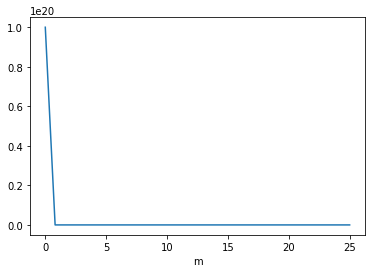

In [33]:
v_x_der_analytic.plot()

The consumption function looks right! Consume all the resources!

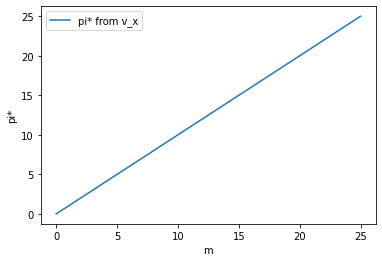

In [35]:
c_sol_v_x.dataset.data_vars['pi*'].plot(x='m', label='pi* from v_x')

plt.legend()

The value function data does not support a good linear interpolation because the true function is so curved.

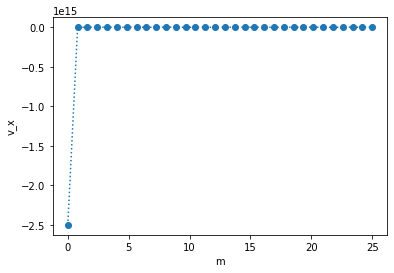

In [36]:
c_sol_v_x.dataset.data_vars['v_x'].plot(marker="o",ls=":",x='m')

But we have instructed the stage to transform this function before interpolating it, which brings back some of the curvature and gives us values that approach $-\infty$ as consumption goes to $0$.

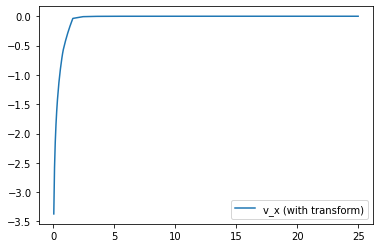

In [37]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol_v_x.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

Note that because of recurving, the marginal value function is not a step function.
However, it is still not smooth, and the abrupt changes will reduce the quality of further computations.

**TODO: Should the computed marginal value function be recurved/transformed somehow?**

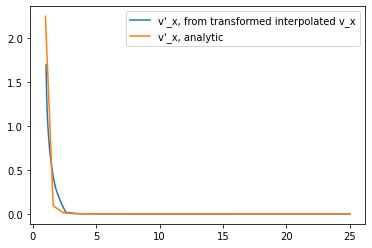

In [38]:
from scipy.misc import derivative

def c_sol_vP_x(mi):
    return derivative(
        lambda m: c_sol_v_x.v_x({'m' : m}),
        mi
    )

m = np.linspace(1,25,500)
plt.plot(m, [c_sol_vP_x(mi) for mi in m], label = 'v\'_x, from transformed interpolated v_x')
plt.plot(m, [v_x_der_analytic.interp({'m' : mi}) for mi in m], label = 'v\'_x, analytic')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

#### T-1 Income

Solve the growth stage with the value function from the previous step.

In [42]:
l_sol_v_x = labor_stage.solve(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol_v_x.v_x
)

i_sol_v_x = investing_stage.solve(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol_v_x.v_x
)

Grid size: 2592
Grid size: 4608


In [43]:
l_sol_v_x_der = labor_stage.solve_v_x_der(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y_der = c_sol_v_x_der.v_x_der
)

i_sol_v_x_der = investing_stage.solve_v_x_der(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y_der = l_sol_v_x_der.v_x_der
)

AttributeError: 'Stage' object has no attribute 'solve_v_x_der'

In [ ]:
i_sol_v_x.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

**TODO: This is interesting but weird....**

In [ ]:
i_sol_v_x_der.dataset.map(np.log).data_vars['v_x_der'].plot(x=None)

In [ ]:
m = np.linspace(-1,25,500)
plt.plot(m, np.exp(i_sol_v_x.v_x({'a' : m, 'alpha' : 0.5})), label = 'e^{v_x} (with transform)')
plt.legend()

In [ ]:
i_sol_v_x

In [ ]:
i_sol_v_x_der

#### T-1 Allocation

Solve allocation stage with value function from previous step.

In [ ]:
# Getting back to normal....

i_sol = i_sol_v_x

In [ ]:
a_sol = allocation_stage.solve_v_x(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

In [ ]:
a_sol

In [ ]:
m = np.linspace(-5,25,500)
plt.plot(m, np.exp(a_sol.v_x({'a' : m})), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

In [ ]:
a_sol.dataset.data_vars['pi*'].plot(x=None)

#### T-2 Consumption

Now, let's do the next round.

In [ ]:
c_sol = consumption_stage.solve_v_x(
    {'m' : x_grid},
    {},
    v_y = a_sol.v_x
)

In [ ]:
c_sol

The roughness of this consumption function is due to the fact that the target $v_y$ function is interpolated.

In [ ]:
c_sol.dataset.data_vars['pi*'].plot(x='m')

In [ ]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

In [ ]:
l_sol = labor_stage.solve_v_x(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol.v_x
)

i_sol = investing_stage.solve_v_x(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol.v_x
)

In [ ]:
i_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

In [ ]:
m = np.linspace(-3,25,500)
plt.plot(m, i_sol.v_x({'a' : m, 'alpha' : 0.5}), label = 'v_x (with transform)')
plt.legend()

In [ ]:
a_sol = allocation_stage.solve_v_x(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

In [ ]:
a_sol

In [ ]:
a_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

In [ ]:
m = np.linspace(-3,25,500)
plt.plot(m, a_sol.v_x({'a' : m}), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

In [ ]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

One more time for good measure!

In [ ]:
l_sol = labor_stage.solve_v_x(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol.v_x
)

i_sol = investing_stage.solve_v_x(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol.v_x
)

In [ ]:
i_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

In [ ]:
m = np.linspace(-3,25,500)
plt.plot(m, i_sol.v_x({'a' : m, 'alpha' : 0.5}), label = 'v_x (with transform)')
plt.legend()

In [ ]:
a_sol = allocation_stage.solve_v_x(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

In [ ]:
m = np.linspace(-3,25,500)
plt.plot(m, a_sol.v_x({'a' : m}), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

In [ ]:
a_sol.dataset.data_vars['pi*'].plot(x=None)

In [ ]:
c_sol = consumption_stage.solve_v_x(
    {'m' : x_grid},
    {},
    v_y = a_sol.v_x
)

In [ ]:
c_sol

In [ ]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

In [ ]:
c_sol.dataset.data_vars['pi*'].plot(x='m')

## Backward Induction Solver

We chain together the stages and iterative solve each stage backwards, feeding $v_x$ into $v_y$, until convergence.

We will use a very coarse grid to start with, for demonstration purposes.

In [ ]:
stages_data = [
    {
        'stage' : consumption_stage,
        'x_grid' : {'m' : np.linspace(epsilon*2,25,40)},
        'optimizer_args' :{
            'a0f' : lambda x: x['m'] - epsilon
        }
    },
    {
        'stage' : allocation_stage,
        'x_grid' : {'a' : np.linspace(epsilon*2,25,35)},
        'optimizer_args' :{}
    },
    {
        'stage' : investing_stage,
        'x_grid' : {
            'a' : np.linspace(epsilon*2,25,25),
            'alpha' : np.linspace(0,1,15)
        },
        'shock_approx_params' : {
            'eta' : 11,
        },
    },
    {
        'stage' : labor_stage,
        'x_grid' : {
            'b' : np.linspace(epsilon*2,25,35),
        },
        'shock_approx_params' : {
            'psi' : 9, 
            'theta' : 9, 
        },
    }
]

We can then solve each stage with backwards induction. Let's do this for one time-period, starting with the trivial terminal value function $v_y = 0$.

In [ ]:
def growth_v_y_terminal(y : Mapping[str,Any]):
    return 0

In [ ]:
sols = backwards_induction(stages_data, growth_v_y_terminal)

In [ ]:
sols[0].v_x({'m' : 3})

In [ ]:
sols[0].dataset.data_vars['v_x']

Now we can run backwards induction with the new (penultimate) value function:

**TODO: This isn't working yet. Getting 'Maximum number of iterations has been exceeded' errors when solving later consumption stages. This must be due to errors in the value function, which I'm working to resolve through generalization of more MicroSolvingDSOP steps. - SB**

In [ ]:
#sols = backwards_induction(stages_data * 2, sols[0].v_x)

Now we have a new consumption function!

It is not smooth because of the coarseness of the discretization grid.

In [ ]:
#sols[0].dataset.data_vars['pi*'].plot(x='m')